In [36]:
#Boiler plate imports
import pandas as pd
import sys
from time import time
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm

#SBND imports
s0 = time()
sys.path.append('/exp/sbnd/app/users/brindenc/analyze_sbnd/pyana')
from sbnd.cafclasses.slice import CAFSlice
from sbnd.cafclasses.pfp import PFP
from sbnd.xsec import response,xsec

#Constants
from sbnd.numu.numu_constants import *
from sbnd.constants import *
from sbnd.flux.prism import PRISM_BINS
from sbnd.flux.constants import *

#Plotters
from sbnd.plotlibrary import makeplot
from sbnd.general import plotters

s1 = time()
print(f'SBND imports: {s1-s0:.2f} s')

%load_ext autoreload
%autoreload 2

SBND imports: 0.00 s
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
#NUMU_INTEGRATED_FLUX/=12 #account for POT
NUMBER_TARGETS_FV,NUMU_INTEGRATED_FLUX/1e11

(5.32188447803213e+31, 9.780976076555024)

In [38]:
#Constants/variables
CUT_MODE = 'roc'
#DATA_DIR  = '/exp/sbnd/data/users/brindenc/analyze_sbnd/numu/v09_78_04_wc_pandora'
#DATA_DIR = '/exp/sbnd/data/users/brindenc/ML/test_fcl/debug_trackid/v4'
DATA_DIR = '/exp/sbnd/data/users/brindenc/analyze_sbnd/numu/v09_82_02_01_pds_gain'
FNAME = f'nom_processed_{CUT_MODE}.df'
HDR_FNAME = 'nom.df'
#FNAME = f'single_processed_{CUT_MODE}.df'
#FNAME = 'single_cut_cosmics_processed.df'
#HDR_FNAME = 'single.df'
#FNAME = f'all_processed_{CUT_MODE}.df'
#FNAME = 'all_processed_roc.df'
#HDR_FNAME = 'all.df'
#FNAME = 'test_processed.df'
#HDR_FNAME = 'test.df'
#NOM_POT = 0.6e20 # stats for first run
LABEL = 'SBND Work in Progress\n0.6e20 POT'
PLOT_DIR = f'Plots/reco_{plotters.day}_{CUT_MODE}/xsec'
SAVE_PLOT = False

In [39]:
#Get data and POT
pfp = PFP.load(f'{DATA_DIR}/{FNAME}','pfp'
               ,prism_bins=PRISM_BINS
               ,momentum_bins=MOMENTUM_BINS
               ,costheta_bins=COSTHETA_BINS
               ,pot=NOM_POT)
slc = CAFSlice.load(f'{DATA_DIR}/{FNAME}','slice'
                    ,prism_bins=PRISM_BINS
                    ,pot=NOM_POT)
hdr = pd.read_hdf(f'{DATA_DIR}/{HDR_FNAME}',key='hdr')
SAMPLE_POT = hdr.pot.sum()

#Scale to nominal POT
print(f'--scaled by {NOM_POT/SAMPLE_POT:.2f}')
pfp.scale_to_pot(NOM_POT,SAMPLE_POT)
slc.scale_to_pot(NOM_POT,SAMPLE_POT)

--scaled by 8.05
--scaling to POT: 7.45e+18 -> 6.00e+19
--scaling to POT: 7.45e+18 -> 6.00e+19


In [40]:
CUTS = ['cosmic','fv','trk','has_muon']
pur,eff,f1 = slc.get_pur_eff_f1(['cosmic','fv','trk','has_muon'])
pur,eff,f1

(array([0.22224323, 0.66998959, 0.81309471, 0.85877658, 0.92076491]),
 array([1.        , 0.7206205 , 0.61017594, 0.57319694, 0.49579174]),
 array([1.        , 0.69438333, 0.69717004, 0.68751007, 0.64453142]))

## 2 Get XSec for bins

### 2.1 Set binning

In [41]:
#First assign binnings, to get efficiency per bin - use truth value
slc.assign_costheta_bins(key='best_muon.costheta',assign_key='best_muon.costheta_bin',costheta_bins=COSTHETA_BINS)
slc.assign_costheta_bins(key='best_muon.truth.p.costheta',assign_key='best_muon.truth.costheta_bin',costheta_bins=COSTHETA_BINS)

In [42]:
momentum_bins = np.array([0.,0.2,0.3,0.5,0.8,1.3,2.5])
slc.assign_momentum_bins(key='best_muon.p',assign_key='best_muon.momentum_bin',momentum_bins=momentum_bins)
slc.assign_momentum_bins(key='best_muon.truth.p.genp.tot',assign_key='best_muon.truth.momentum_bin',momentum_bins=momentum_bins)

### 2.2 XSec calc

$\frac{d\sigma}{dx} = \frac{N_i-B_i}{\epsilon_i n_t \Phi dx_i}$

In [52]:
slc_cut = slc.copy()
for cut in CUTS:
    slc_cut.apply_cut(cut)
slc_bkg = slc_cut.copy()
slc_bkg.data = slc_bkg.data[(slc_bkg.data.truth.event_type != 0).values]

Applied cut on key: cut.cosmic (201,014 --> 48,050)
Applied cut on key: cut.fv (48,050 --> 33,525)
Applied cut on key: cut.trk (33,525 --> 29,818)
Applied cut on key: cut.has_muon (29,818 --> 24,055)


In [58]:
#costheta
n_i = slc_cut.get_binned_numevents('best_muon.truth.costheta_bin')
b_i = slc_bkg.get_binned_numevents('best_muon.truth.costheta_bin')
phi = NUMU_INTEGRATED_FLUX
nt = NUMBER_TARGETS_FV
dxs = np.diff(COSTHETA_BINS)


In [59]:
dxs

array([0.5 , 0.5 , 0.27, 0.18, 0.17, 0.14, 0.1 , 0.08, 0.06])

In [56]:
n_i-b_i

array([ 6857.1711764 ,  9239.47477759,  9336.05465331, 12120.77440335,
       19895.45439913, 26358.25774964, 27710.37600977, 32877.39936104,
       33231.52557205])

In [ ]:
def calc_xsec()

In [ ]:
slc

In [153]:
d2x_dpdc_dict,meta_dict = xsec.get_d2xsec_dxdy_dict(slc,
            'best_muon.costheta',
            'best_muon.p',
            ''
            COSTHETA_BINS,
            EdgesP,
            'best_muon.costheta_bin',
            'best_muon.momentum_bin',
            costheta_smearing_matrix,
            momentum_smearing_matrix,
            cuts=CUTS)

xbin (-1.0,-0.5]


5it [00:00,  7.47it/s]


ybin (0.0,0.18]
0 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0. 1.]
0 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0. 1.]
Applied cut on key: cut.cosmic (65 --> 23)
Applied cut on key: cut.fv (23 --> 18)
Applied cut on key: cut.trk (18 --> 18)
Applied cut on key: cut.has_muon (18 --> 18)
0 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0. 1.]
0 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0. 1.]


Calculating responses: 1it [00:00, 5991.86it/s]
Calculating responses: 1it [00:00, 8719.97it/s]

ybin (0.18,0.3]


0 [0 0 0 ... 0 0 0]
[0. 1.]
1 [1 1 1 ... 1 1 1]
[0. 1. 2.]
Applied cut on key: cut.cosmic (1,327 --> 636)
Applied cut on key: cut.fv (636 --> 535)
Applied cut on key: cut.trk (535 --> 535)
Applied cut on key: cut.has_muon (535 --> 535)
0 [0 0 0 ... 0 0 0]
[0. 1.]
1 [1 1 1 ... 1 1 1]
[0. 1. 2.]


Calculating responses: 1it [00:00, 4462.03it/s]
Calculating responses: 2it [00:00, 9986.44it/s]

ybin (0.3,0.45]


0 [0 0 0 ... 0 0 0]
[0. 1.]
2 [2 2 2 ... 2 2 2]
[0. 1. 2. 3.]
Applied cut on key: cut.cosmic (1,622 --> 649)
Applied cut on key: cut.fv (649 --> 539)
Applied cut on key: cut.trk (539 --> 539)
Applied cut on key: cut.has_muon (539 --> 539)
0 [0 0 0 ... 0 0 0]
[0. 1.]
2 [2 2 2 ... 2 2 2]
[0. 1. 2. 3.]


Calculating responses: 1it [00:00, 4804.47it/s]
Calculating responses: 3it [00:00, 15907.60it/s]

ybin (0.45,0.77]


0 [0 0 0 ... 0 0 0]
[0. 1.]
3 [3 3 3 ... 3 3 3]
[0. 1. 2. 3. 4.]
Applied cut on key: cut.cosmic (1,048 --> 322)
Applied cut on key: cut.fv (322 --> 250)
Applied cut on key: cut.trk (250 --> 250)
Applied cut on key: cut.has_muon (250 --> 250)
0 [0 0 0 ... 0 0 0]
[0. 1.]
3 [3 3 3 ... 3 3 3]
[0. 1. 2. 3. 4.]


Calculating responses: 1it [00:00, 5698.78it/s]
Calculating responses: 4it [00:00, 18456.78it/s]

ybin (0.77,2.5]


0 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 

Calculating responses: 1it [00:00, 5005.14it/s]
Calculating responses: 5it [00:00, 21290.88it/s]

xbin (-0.5,0.0]



5it [00:00,  6.00it/s]


ybin (0.0,0.18]
1 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0. 1. 2.]
0 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0. 1.]
Applied cut on key: cut.cosmic (60 --> 14)
Applied cut on key: cut.fv (14 --> 12)
Applied cut on key: cut.trk (12 --> 12)
Applied cut on key: cut.has_muon (12 --> 12)
1 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0. 1. 2.]
0 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0. 1.]


Calculating responses: 2it [00:00, 11538.66it/s]
Calculating responses: 1it [00:00, 8371.86it/s]

ybin (0.18,0.3]


1 [1 1 1 ... 1 1 1]
[0. 1. 2.]
1 [1 1 1 ... 1 1 1]
[0. 1. 2.]
Applied cut on key: cut.cosmic (1,728 --> 422)
Applied cut on key: cut.fv (422 --> 348)
Applied cut on key: cut.trk (348 --> 348)
Applied cut on key: cut.has_muon (348 --> 348)
1 [1 1 1 ... 1 1 1]
[0. 1. 2.]
1 [1 1 1 ... 1 1 1]
[0. 1. 2.]


Calculating responses: 2it [00:00, 16677.15it/s]
Calculating responses: 2it [00:00, 13231.24it/s]

ybin (0.3,0.45]


1 [1 1 1 ... 1 1 1]
[0. 1. 2.]
2 [2 2 2 ... 2 2 2]
[0. 1. 2. 3.]
Applied cut on key: cut.cosmic (2,997 --> 727)
Applied cut on key: cut.fv (727 --> 624)
Applied cut on key: cut.trk (624 --> 624)
Applied cut on key: cut.has_muon (624 --> 624)
1 [1 1 1 ... 1 1 1]
[0. 1. 2.]
2 [2 2 2 ... 2 2 2]
[0. 1. 2. 3.]


Calculating responses: 2it [00:00, 17586.18it/s]
Calculating responses: 3it [00:00, 29537.35it/s]

ybin (0.45,0.77]


1 [1 1 1 ... 1 1 1]
[0. 1. 2.]
3 [3 3 3 ... 3 3 3]
[0. 1. 2. 3. 4.]
Applied cut on key: cut.cosmic (2,053 --> 176)
Applied cut on key: cut.fv (176 --> 151)
Applied cut on key: cut.trk (151 --> 151)
Applied cut on key: cut.has_muon (151 --> 151)
1 [1 1 1 ... 1 1 1]
[0. 1. 2.]
3 [3 3 3 ... 3 3 3]
[0. 1. 2. 3. 4.]


Calculating responses: 2it [00:00, 17084.74it/s]
Calculating responses: 4it [00:00, 32704.12it/s]

ybin (0.77,2.5]


1 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 

Calculating responses: 2it [00:00, 14027.77it/s]
Calculating responses: 5it [00:00, 39125.97it/s]

xbin (0.0,0.27]



5it [00:02,  1.74it/s]


ybin (0.0,0.18]
2 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[0. 1. 2. 3.]
0 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0. 1.]
Applied cut on key: cut.cosmic (58 --> 10)
Applied cut on key: cut.fv (10 --> 9)
Applied cut on key: cut.trk (9 --> 9)
Applied cut on key: cut.has_muon (9 --> 9)
2 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[0. 1. 2. 3.]
0 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0. 1.]


Calculating responses: 3it [00:00, 17722.41it/s]
Calculating responses: 1it [00:00, 6615.62it/s]

ybin (0.18,0.3]


2 [2 2 2 ... 2 2 2]
[0. 1. 2. 3.]
1 [1 1 1 ... 1 1 1]
[0. 1. 2.]
Applied cut on key: cut.cosmic (1,801 --> 311)
Applied cut on key: cut.fv (311 --> 241)
Applied cut on key: cut.trk (241 --> 241)
Applied cut on key: cut.has_muon (241 --> 241)
2 [2 2 2 ... 2 2 2]
[0. 1. 2. 3.]
1 [1 1 1 ... 1 1 1]
[0. 1. 2.]


Calculating responses: 3it [00:00, 19722.43it/s]
Calculating responses: 2it [00:00, 16352.06it/s]

ybin (0.3,0.45]


2 [2 2 2 ... 2 2 2]
[0. 1. 2. 3.]
2 [2 2 2 ... 2 2 2]
[0. 1. 2. 3.]
Applied cut on key: cut.cosmic (4,798 --> 770)
Applied cut on key: cut.fv (770 --> 615)
Applied cut on key: cut.trk (615 --> 615)
Applied cut on key: cut.has_muon (615 --> 615)
2 [2 2 2 ... 2 2 2]
[0. 1. 2. 3.]
2 [2 2 2 ... 2 2 2]
[0. 1. 2. 3.]


Calculating responses: 3it [00:00, 15553.66it/s]
Calculating responses: 3it [00:00, 21041.66it/s]

ybin (0.45,0.77]


2 [2 2 2 ... 2 2 2]
[0. 1. 2. 3.]
3 [3 3 3 ... 3 3 3]
[0. 1. 2. 3. 4.]
Applied cut on key: cut.cosmic (6,373 --> 456)
Applied cut on key: cut.fv (456 --> 386)
Applied cut on key: cut.trk (386 --> 386)
Applied cut on key: cut.has_muon (386 --> 386)
2 [2 2 2 ... 2 2 2]
[0. 1. 2. 3.]
3 [3 3 3 ... 3 3 3]
[0. 1. 2. 3. 4.]


Calculating responses: 3it [00:00, 19152.07it/s]
Calculating responses: 4it [00:00, 32201.95it/s]

ybin (0.77,2.5]


2 [2 2 2 ... 2 2 2]
[0. 1. 2. 3.]
4 [4 4 4 ... 4 4 4]
[0. 1. 2. 3. 4. 5.]
Applied cut on key: cut.cosmic (4,021 --> 42)
Applied cut on key: cut.fv (42 --> 34)
Applied cut on key: cut.trk (34 --> 34)
Applied cut on key: cut.has_muon (34 --> 34)
2 [2 2 2 ... 2 2 2]
[0. 1. 2. 3.]
4 [4 4 4 ... 4 4 4]
[0. 1. 2. 3. 4. 5.]


Calculating responses: 3it [00:00, 28339.89it/s]
Calculating responses: 5it [00:00, 45789.34it/s]

xbin (0.27,0.45]



4it [00:01,  2.18it/s]


ybin (0.0,0.3]
3 [3 3 3 ... 3 3 3]
[0. 1. 2. 3. 4.]
0 [0 0 0 ... 0 0 0]
[0. 1.]
Applied cut on key: cut.cosmic (1,891 --> 351)
Applied cut on key: cut.fv (351 --> 253)
Applied cut on key: cut.trk (253 --> 253)
Applied cut on key: cut.has_muon (253 --> 253)
3 [3 3 3 ... 3 3 3]
[0. 1. 2. 3. 4.]
0 [0 0 0 ... 0 0 0]
[0. 1.]


Calculating responses: 4it [00:00, 36235.89it/s]
Calculating responses: 1it [00:00, 10810.06it/s]

ybin (0.3,0.45]


3 [3 3 3 ... 3 3 3]
[0. 1. 2. 3. 4.]
1 [1 1 1 ... 1 1 1]
[0. 1. 2.]
Applied cut on key: cut.cosmic (4,334 --> 908)
Applied cut on key: cut.fv (908 --> 695)
Applied cut on key: cut.trk (695 --> 695)
Applied cut on key: cut.has_muon (695 --> 695)
3 [3 3 3 ... 3 3 3]
[0. 1. 2. 3. 4.]
1 [1 1 1 ... 1 1 1]
[0. 1. 2.]


Calculating responses: 4it [00:00, 35620.42it/s]
Calculating responses: 2it [00:00, 20262.34it/s]

ybin (0.45,0.77]


3 [3 3 3 ... 3 3 3]
[0. 1. 2. 3. 4.]
2 [2 2 2 ... 2 2 2]
[0. 1. 2. 3.]
Applied cut on key: cut.cosmic (5,593 --> 843)
Applied cut on key: cut.fv (843 --> 686)
Applied cut on key: cut.trk (686 --> 686)
Applied cut on key: cut.has_muon (686 --> 686)
3 [3 3 3 ... 3 3 3]
[0. 1. 2. 3. 4.]
2 [2 2 2 ... 2 2 2]
[0. 1. 2. 3.]


Calculating responses: 4it [00:00, 33621.68it/s]
Calculating responses: 3it [00:00, 29059.84it/s]

ybin (0.77,2.5]


3 [3 3 3 ... 3 3 3]
[0. 1. 2. 3. 4.]
3 [3 3 3 ... 3 3 3]
[0. 1. 2. 3. 4.]
Applied cut on key: cut.cosmic (3,884 --> 100)
Applied cut on key: cut.fv (100 --> 84)
Applied cut on key: cut.trk (84 --> 84)
Applied cut on key: cut.has_muon (84 --> 84)
3 [3 3 3 ... 3 3 3]
[0. 1. 2. 3. 4.]
3 [3 3 3 ... 3 3 3]
[0. 1. 2. 3. 4.]


Calculating responses: 4it [00:00, 33893.37it/s]
Calculating responses: 4it [00:00, 37532.92it/s]

xbin (0.45,0.62]



4it [00:01,  2.09it/s]


ybin (0.0,0.3]
4 [4 4 4 ... 4 4 4]
[0. 1. 2. 3. 4. 5.]
0 [0 0 0 ... 0 0 0]
[0. 1.]
Applied cut on key: cut.cosmic (1,667 --> 378)
Applied cut on key: cut.fv (378 --> 277)
Applied cut on key: cut.trk (277 --> 277)
Applied cut on key: cut.has_muon (277 --> 277)
4 [4 4 4 ... 4 4 4]
[0. 1. 2. 3. 4. 5.]
0 [0 0 0 ... 0 0 0]
[0. 1.]


Calculating responses: 5it [00:00, 39794.16it/s]
Calculating responses: 1it [00:00, 10230.01it/s]

ybin (0.3,0.45]


4 [4 4 4 ... 4 4 4]
[0. 1. 2. 3. 4. 5.]
1 [1 1 1 ... 1 1 1]
[0. 1. 2.]
Applied cut on key: cut.cosmic (3,944 --> 1,104)
Applied cut on key: cut.fv (1,104 --> 853)
Applied cut on key: cut.trk (853 --> 853)
Applied cut on key: cut.has_muon (853 --> 853)
4 [4 4 4 ... 4 4 4]
[0. 1. 2. 3. 4. 5.]
1 [1 1 1 ... 1 1 1]
[0. 1. 2.]


Calculating responses: 5it [00:00, 27060.03it/s]
Calculating responses: 2it [00:00, 17886.16it/s]

ybin (0.45,0.77]


4 [4 4 4 ... 4 4 4]
[0. 1. 2. 3. 4. 5.]
2 [2 2 2 ... 2 2 2]
[0. 1. 2. 3.]
Applied cut on key: cut.cosmic (5,673 --> 1,603)
Applied cut on key: cut.fv (1,603 --> 1,311)
Applied cut on key: cut.trk (1,311 --> 1,311)
Applied cut on key: cut.has_muon (1,311 --> 1,311)
4 [4 4 4 ... 4 4 4]
[0. 1. 2. 3. 4. 5.]
2 [2 2 2 ... 2 2 2]
[0. 1. 2. 3.]


Calculating responses: 5it [00:00, 31726.96it/s]
Calculating responses: 3it [00:00, 19909.67it/s]

ybin (0.77,2.5]


4 [4 4 4 ... 4 4 4]
[0. 1. 2. 3. 4. 5.]
3 [3 3 3 ... 3 3 3]
[0. 1. 2. 3. 4.]
Applied cut on key: cut.cosmic (4,316 --> 321)
Applied cut on key: cut.fv (321 --> 260)
Applied cut on key: cut.trk (260 --> 260)
Applied cut on key: cut.has_muon (260 --> 260)
4 [4 4 4 ... 4 4 4]
[0. 1. 2. 3. 4. 5.]
3 [3 3 3 ... 3 3 3]
[0. 1. 2. 3. 4.]


Calculating responses: 5it [00:00, 23405.71it/s]
Calculating responses: 4it [00:00, 31714.96it/s]

xbin (0.62,0.76]



4it [00:02,  1.69it/s]


ybin (0.0,0.3]
5 [5 5 5 ... 5 5 5]
[0. 1. 2. 3. 4. 5. 6.]
0 [0 0 0 ... 0 0 0]
[0. 1.]
Applied cut on key: cut.cosmic (1,174 --> 374)
Applied cut on key: cut.fv (374 --> 248)
Applied cut on key: cut.trk (248 --> 248)
Applied cut on key: cut.has_muon (248 --> 248)
5 [5 5 5 ... 5 5 5]
[0. 1. 2. 3. 4. 5. 6.]
0 [0 0 0 ... 0 0 0]
[0. 1.]


Calculating responses: 6it [00:00, 34663.67it/s]
Calculating responses: 1it [00:00, 8683.86it/s]

ybin (0.3,0.45]


5 [5 5 5 ... 5 5 5]
[0. 1. 2. 3. 4. 5. 6.]
1 [1 1 1 ... 1 1 1]
[0. 1. 2.]
Applied cut on key: cut.cosmic (2,818 --> 1,072)
Applied cut on key: cut.fv (1,072 --> 802)
Applied cut on key: cut.trk (802 --> 802)
Applied cut on key: cut.has_muon (802 --> 802)
5 [5 5 5 ... 5 5 5]
[0. 1. 2. 3. 4. 5. 6.]
1 [1 1 1 ... 1 1 1]
[0. 1. 2.]


Calculating responses: 6it [00:00, 27624.40it/s]
Calculating responses: 2it [00:00, 12446.01it/s]

ybin (0.45,0.77]


5 [5 5 5 ... 5 5 5]
[0. 1. 2. 3. 4. 5. 6.]
2 [2 2 2 ... 2 2 2]
[0. 1. 2. 3.]
Applied cut on key: cut.cosmic (5,008 --> 2,196)
Applied cut on key: cut.fv (2,196 --> 1,741)
Applied cut on key: cut.trk (1,741 --> 1,741)
Applied cut on key: cut.has_muon (1,741 --> 1,741)
5 [5 5 5 ... 5 5 5]
[0. 1. 2. 3. 4. 5. 6.]
2 [2 2 2 ... 2 2 2]
[0. 1. 2. 3.]


Calculating responses: 6it [00:00, 26024.64it/s]
Calculating responses: 3it [00:00, 18157.16it/s]

ybin (0.77,2.5]


5 [5 5 5 ... 5 5 5]
[0. 1. 2. 3. 4. 5. 6.]
3 [3 3 3 ... 3 3 3]
[0. 1. 2. 3. 4.]
Applied cut on key: cut.cosmic (4,885 --> 883)
Applied cut on key: cut.fv (883 --> 725)
Applied cut on key: cut.trk (725 --> 725)
Applied cut on key: cut.has_muon (725 --> 725)
5 [5 5 5 ... 5 5 5]
[0. 1. 2. 3. 4. 5. 6.]
3 [3 3 3 ... 3 3 3]
[0. 1. 2. 3. 4.]


Calculating responses: 6it [00:00, 25165.82it/s]
Calculating responses: 4it [00:00, 21931.00it/s]

xbin (0.76,0.86]



5it [00:02,  2.32it/s]


ybin (0.0,0.3]
6 [6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6

Calculating responses: 7it [00:00, 41178.30it/s]
Calculating responses: 1it [00:00, 6775.94it/s]

ybin (0.3,0.45]


6 [6 6 6 ... 6 6 6]
[0. 1. 2. 3. 4. 5. 6. 7.]
1 [1 1 1 ... 1 1 1]
[0. 1. 2.]
Applied cut on key: cut.cosmic (1,661 --> 823)
Applied cut on key: cut.fv (823 --> 506)
Applied cut on key: cut.trk (506 --> 506)
Applied cut on key: cut.has_muon (506 --> 506)
6 [6 6 6 ... 6 6 6]
[0. 1. 2. 3. 4. 5. 6. 7.]
1 [1 1 1 ... 1 1 1]
[0. 1. 2.]


Calculating responses: 7it [00:00, 42063.22it/s]
Calculating responses: 2it [00:00, 14463.12it/s]

ybin (0.45,0.77]


6 [6 6 6 ... 6 6 6]
[0. 1. 2. 3. 4. 5. 6. 7.]
2 [2 2 2 ... 2 2 2]
[0. 1. 2. 3.]
Applied cut on key: cut.cosmic (3,684 --> 1,967)
Applied cut on key: cut.fv (1,967 --> 1,459)
Applied cut on key: cut.trk (1,459 --> 1,459)
Applied cut on key: cut.has_muon (1,459 --> 1,459)
6 [6 6 6 ... 6 6 6]
[0. 1. 2. 3. 4. 5. 6. 7.]
2 [2 2 2 ... 2 2 2]
[0. 1. 2. 3.]


Calculating responses: 7it [00:00, 44150.57it/s]
Calculating responses: 3it [00:00, 7244.05it/s]

ybin (0.77,1.28]


6 [6 6 6 ... 6 6 6]
[0. 1. 2. 3. 4. 5. 6. 7.]
3 [3 3 3 ... 3 3 3]
[0. 1. 2. 3. 4.]
Applied cut on key: cut.cosmic (3,182 --> 1,454)
Applied cut on key: cut.fv (1,454 --> 1,177)
Applied cut on key: cut.trk (1,177 --> 1,177)
Applied cut on key: cut.has_muon (1,177 --> 1,177)
6 [6 6 6 ... 6 6 6]
[0. 1. 2. 3. 4. 5. 6. 7.]
3 [3 3 3 ... 3 3 3]
[0. 1. 2. 3. 4.]


Calculating responses: 7it [00:00, 41823.54it/s]
Calculating responses: 4it [00:00, 36472.21it/s]

ybin (1.28,2.5]


6 [6 6 6 ... 6 6 6]
[0. 1. 2. 3. 4. 5. 6. 7.]
4 [4 4 4 ... 4 4 4]
[0. 1. 2. 3. 4. 5.]
Applied cut on key: cut.cosmic (2,597 --> 282)
Applied cut on key: cut.fv (282 --> 225)
Applied cut on key: cut.trk (225 --> 225)
Applied cut on key: cut.has_muon (225 --> 225)
6 [6 6 6 ... 6 6 6]
[0. 1. 2. 3. 4. 5. 6. 7.]
4 [4 4 4 ... 4 4 4]
[0. 1. 2. 3. 4. 5.]


Calculating responses: 7it [00:00, 42799.02it/s]
Calculating responses: 5it [00:00, 35971.73it/s]

xbin (0.86,0.94]



5it [00:01,  2.55it/s]


ybin (0.0,0.3]
7 [7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7

Calculating responses: 8it [00:00, 42853.68it/s]
Calculating responses: 1it [00:00, 6168.09it/s]

ybin (0.3,0.45]


7 [7 7 7 ... 7 7 7]
[0. 1. 2. 3. 4. 5. 6. 7. 8.]
1 [1 1 1 ... 1 1 1]
[0. 1. 2.]
Applied cut on key: cut.cosmic (1,430 --> 873)
Applied cut on key: cut.fv (873 --> 464)
Applied cut on key: cut.trk (464 --> 464)
Applied cut on key: cut.has_muon (464 --> 464)
7 [7 7 7 ... 7 7 7]
[0. 1. 2. 3. 4. 5. 6. 7. 8.]
1 [1 1 1 ... 1 1 1]
[0. 1. 2.]


Calculating responses: 8it [00:00, 41838.44it/s]
Calculating responses: 2it [00:00, 14979.66it/s]

ybin (0.45,0.77]


7 [7 7 7 ... 7 7 7]
[0. 1. 2. 3. 4. 5. 6. 7. 8.]
2 [2 2 2 ... 2 2 2]
[0. 1. 2. 3.]
Applied cut on key: cut.cosmic (3,375 --> 2,281)
Applied cut on key: cut.fv (2,281 --> 1,449)
Applied cut on key: cut.trk (1,449 --> 1,449)
Applied cut on key: cut.has_muon (1,449 --> 1,449)
7 [7 7 7 ... 7 7 7]
[0. 1. 2. 3. 4. 5. 6. 7. 8.]
2 [2 2 2 ... 2 2 2]
[0. 1. 2. 3.]


Calculating responses: 8it [00:00, 30812.15it/s]
Calculating responses: 3it [00:00, 16980.99it/s]

ybin (0.77,1.28]


7 [7 7 7 ... 7 7 7]
[0. 1. 2. 3. 4. 5. 6. 7. 8.]
3 [3 3 3 ... 3 3 3]
[0. 1. 2. 3. 4.]
Applied cut on key: cut.cosmic (3,495 --> 2,141)
Applied cut on key: cut.fv (2,141 --> 1,582)
Applied cut on key: cut.trk (1,582 --> 1,582)
Applied cut on key: cut.has_muon (1,582 --> 1,582)
7 [7 7 7 ... 7 7 7]
[0. 1. 2. 3. 4. 5. 6. 7. 8.]
3 [3 3 3 ... 3 3 3]
[0. 1. 2. 3. 4.]


Calculating responses: 8it [00:00, 50382.03it/s]
Calculating responses: 4it [00:00, 24600.02it/s]

ybin (1.28,2.5]


7 [7 7 7 ... 7 7 7]
[0. 1. 2. 3. 4. 5. 6. 7. 8.]
4 [4 4 4 ... 4 4 4]
[0. 1. 2. 3. 4. 5.]
Applied cut on key: cut.cosmic (2,188 --> 792)
Applied cut on key: cut.fv (792 --> 642)
Applied cut on key: cut.trk (642 --> 642)
Applied cut on key: cut.has_muon (642 --> 642)
7 [7 7 7 ... 7 7 7]
[0. 1. 2. 3. 4. 5. 6. 7. 8.]
4 [4 4 4 ... 4 4 4]
[0. 1. 2. 3. 4. 5.]


Calculating responses: 8it [00:00, 39429.41it/s]
Calculating responses: 5it [00:00, 33182.78it/s]

xbin (0.94,1.0]



5it [00:01,  3.16it/s]


ybin (0.0,0.3]
8 [8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]
[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
0 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

Calculating responses: 9it [00:00, 44567.57it/s]
Calculating responses: 1it [00:00, 6043.67it/s]

ybin (0.3,0.45]


8 [8 8 8 ... 8 8 8]
[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
1 [1 1 1 ... 1 1 1]
[0. 1. 2.]
Applied cut on key: cut.cosmic (1,224 --> 884)
Applied cut on key: cut.fv (884 --> 429)
Applied cut on key: cut.trk (429 --> 429)
Applied cut on key: cut.has_muon (429 --> 429)
8 [8 8 8 ... 8 8 8]
[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
1 [1 1 1 ... 1 1 1]
[0. 1. 2.]


Calculating responses: 9it [00:00, 39988.07it/s]
Calculating responses: 2it [00:00, 13957.75it/s]

ybin (0.45,0.77]


8 [8 8 8 ... 8 8 8]
[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
2 [2 2 2 ... 2 2 2]
[0. 1. 2. 3.]
Applied cut on key: cut.cosmic (2,849 --> 2,217)
Applied cut on key: cut.fv (2,217 --> 1,152)
Applied cut on key: cut.trk (1,152 --> 1,152)
Applied cut on key: cut.has_muon (1,152 --> 1,152)
8 [8 8 8 ... 8 8 8]
[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
2 [2 2 2 ... 2 2 2]
[0. 1. 2. 3.]


Calculating responses: 9it [00:00, 41573.50it/s]
Calculating responses: 3it [00:00, 28212.81it/s]

ybin (0.77,1.28]


8 [8 8 8 ... 8 8 8]
[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
3 [3 3 3 ... 3 3 3]
[0. 1. 2. 3. 4.]
Applied cut on key: cut.cosmic (3,483 --> 2,562)
Applied cut on key: cut.fv (2,562 --> 1,475)
Applied cut on key: cut.trk (1,475 --> 1,475)
Applied cut on key: cut.has_muon (1,475 --> 1,475)
8 [8 8 8 ... 8 8 8]
[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
3 [3 3 3 ... 3 3 3]
[0. 1. 2. 3. 4.]


Calculating responses: 9it [00:00, 40072.97it/s]
Calculating responses: 4it [00:00, 19972.88it/s]

ybin (1.28,2.5]


8 [8 8 8 ... 8 8 8]
[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
4 [4 4 4 ... 4 4 4]
[0. 1. 2. 3. 4. 5.]
Applied cut on key: cut.cosmic (2,216 --> 1,361)
Applied cut on key: cut.fv (1,361 --> 855)
Applied cut on key: cut.trk (855 --> 855)
Applied cut on key: cut.has_muon (855 --> 855)
8 [8 8 8 ... 8 8 8]
[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
4 [4 4 4 ... 4 4 4]
[0. 1. 2. 3. 4. 5.]


Calculating responses: 9it [00:00, 46834.66it/s]
Calculating responses: 5it [00:00, 35305.59it/s]


In [47]:
#Get variables for double differential cross section
d2x_dpdc_dict = {} # keys are (costheta_bin,momentum_bin)

for i,c in tqdm(enumerate(COSTHETA_BINS)):
    if i == len(COSTHETA_BINS)-1: continue
    mom_bins = EdgesP[i]
    _slc = slc.copy()
    _slc.data = _slc.data[_slc.data.best_muon.costheta_bin == i]
    _slc.assign_momentum_bins(momentum_bins=mom_bins) #have to reassign since microboone uses wtf bins
    for j,p in enumerate(mom_bins): #We will use MicroBoone binning for now
        if j == len(mom_bins)-1: continue
        dc = COSTHETA_BINS[i+1] - c
        dp = mom_bins[j+1] - p
        #Get efficiency
        _slc_ = _slc.copy()
        _slc_.data = _slc_.data[_slc_.data.best_muon.momentum_bin == j]
        pur,eff,_ = _slc_.get_pur_eff_f1(CUTS)
        #Get n_i,b_i
        _slc_cut = _slc_.copy()
        for cut in CUTS:
            _slc_cut.apply_cut(cut)
        n_i = _slc_cut.data.genweight[_slc_cut.data.truth.event_type == 0].sum()
        b_i = _slc_cut.data.genweight[_slc_cut.data.truth.event_type != 0].sum()
        #Get d2dx_dpdc
        d2x_dpdc = (n_i-b_i)/(dc*dp*eff[-1]*NUMBER_TARGETS_FV*NUMU_INTEGRATED_FLUX)
        #Get unc
        stat_unc = 1/np.sqrt(n_i + b_i)
        d2x_dpdc_dict[(i,j)] = {'dc':dc,'dp':dp,'eff':eff[-1],'pur':pur[-1],'n_i':n_i,'b_i':b_i,'stat_unc':stat_unc,'d2x_dpdc':d2x_dpdc,'mom_bins':mom_bins}


0it [00:00, ?it/s]

5it [00:00, 10.77it/s]
5it [00:00,  5.89it/s]
5it [00:02,  2.49it/s]
4it [00:01,  2.77it/s]
4it [00:01,  2.71it/s]
4it [00:01,  2.77it/s]
5it [00:01,  3.08it/s]
5it [00:01,  3.68it/s]
5it [00:01,  4.46it/s]
10it [00:38,  3.81s/it]


In [65]:
#Get variables for single differential cross section
dx_dp_dict = {} # keys are (momentum_bin)
for i,p in tqdm(enumerate(momentum_bins)):
    if i == len(momentum_bins)-1: continue
    dp = momentum_bins[i+1] - p
    #Get efficiency
    _slc = slc.copy()
    _slc.data = _slc.data[_slc.data.best_muon.momentum_bin == i]
    pur,eff,_ = _slc.get_pur_eff_f1(CUTS)
    #Get n_i,b_i
    _slc_cut = _slc.copy()
    for cut in CUTS:
        _slc_cut.apply_cut(cut)
    n_i = _slc_cut.data.genweight[_slc_cut.data.truth.event_type == 0].sum()
    b_i = _slc_cut.data.genweight[_slc_cut.data.truth.event_type != 0].sum()
    #Get xsec
    dx_dp = (n_i-b_i)/(dp*eff[-1]*NUMBER_TARGETS_FV*NUMU_INTEGRATED_FLUX)
    #Get unc
    stat_unc = 1/np.sqrt(n_i + b_i)
    dx_dp_dict[i] = {'dp':dp,'eff':eff[-1],'pur':pur[-1],'n_i':n_i,'b_i':b_i,'stat_unc':stat_unc,'dx_dp':dx_dp}

0it [00:00, ?it/s]

7it [00:11,  1.59s/it]


In [49]:
dx_dc_dict = {} # keys are (costheta_bin)
for i,c in tqdm(enumerate(COSTHETA_BINS)):
    if i == len(COSTHETA_BINS)-1: continue
    dc = COSTHETA_BINS[i+1] - c
    #Get efficiency
    _slc = slc.copy()
    _slc.data = _slc.data[_slc.data.best_muon.costheta_bin == i]
    pur,eff,_ = _slc.get_pur_eff_f1(CUTS)
    #Get n_i,b_i
    _slc_cut = _slc.copy()
    for cut in CUTS:
        _slc_cut.apply_cut(cut)
    n_i = _slc_cut.data.genweight[_slc_cut.data.truth.event_type == 0].sum()
    b_i = _slc_cut.data.genweight[_slc_cut.data.truth.event_type != 0].sum()
    #Get xsec
    dx_dc = (n_i-b_i)/(dc*eff[-1]*NUMBER_TARGETS_FV*NUMU_INTEGRATED_FLUX)
    #Get unc
    stat_unc = 1/np.sqrt(n_i + b_i)
    dx_dc_dict[i] = {'dc':dc,'eff':eff[-1],'pur':pur[-1],'n_i':n_i,'b_i':b_i,'stat_unc':stat_unc,'dx_dc':dx_dc}

0it [00:00, ?it/s]

10it [00:15,  1.57s/it]


In [50]:
d2x_dpdc_dict[(0,0)],dx_dc_dict[8],dx_dp_dict[8]

({'dc': 0.5,
  'dp': 0.18,
  'eff': 0.4074074074074073,
  'pur': 0.6111111111111109,
  'n_i': 88.5315527469295,
  'b_i': 56.33826083895514,
  'stat_unc': 0.08308278564283073,
  'd2x_dpdc': 1.6867329050888078e-41,
  'mom_bins': [0.0, 0.18, 0.3, 0.45, 0.77, 2.5]},
 {'dc': 0.06000000000000005,
  'eff': 0.7918276072372433,
  'pur': 0.9197166469893743,
  'n_i': 31348.217995390034,
  'b_i': 2736.429812177821,
  'stat_unc': 0.005416523036918624,
  'dx_dc': 1.156952347585777e-38},
 {'dp': 1.0,
  'eff': 0.7602230483271376,
  'pur': 0.9359267734553777,
  'n_i': 3291.7640975903787,
  'b_i': 225.35304335582063,
  'stat_unc': 0.01686190287498597,
  'dx_dp': 7.748929322763298e-41})

## 3. Single Differential Plots
$\frac{d\sigma}{dx} = \frac{N_i-B_i}{\epsilon_i n_t \Phi dx_i}$

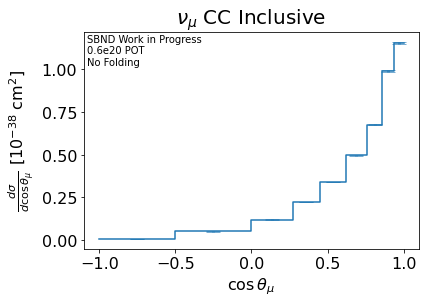

In [51]:
#dx_dc
dx_dcs = np.zeros(len(COSTHETA_BINS)-1)
errs = dx_dcs.copy()
scale = 1e38
for i in range(len(COSTHETA_BINS)-1):
    dx_dcs[i] = dx_dc_dict[i]['dx_dc']*scale
    #TODO: incorperate systematic unc
    errs[i] = dx_dc_dict[i]['stat_unc']*dx_dc_dict[i]['dx_dc']*scale

fig,ax = plt.subplots(figsize=(6,4))
makeplot.plot_hist_edges(COSTHETA_BINS,dx_dcs,errs,'',ax=ax)
ax.set_xlabel(r'$\cos\theta_\mu$')
ax.set_ylabel(r'$\frac{d\sigma}{d\cos\theta_\mu}$ [$10^{-38}$ cm$^2$]')
ax.set_title(r'$\nu_\mu$ CC Inclusive')
plotters.set_style(ax)
plotters.add_label(ax,LABEL+'\nNo Folding',where='topleft')
if SAVE_PLOT:
    plotters.save_plot(f'dx_dc',fig=fig,folder_name=PLOT_DIR)
    #plt.close()

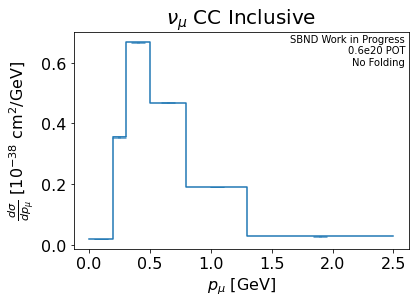

In [66]:
#dx_dp
dx_dps = np.zeros(len(momentum_bins)-1)
errs = dx_dps.copy()
scale = 1e38
for i in range(len(momentum_bins)-1):
    dx_dps[i] = dx_dp_dict[i]['dx_dp']*scale
    errs[i] = dx_dp_dict[i]['stat_unc']*dx_dp_dict[i]['dx_dp']*scale

fig,ax = plt.subplots(figsize=(6,4))
makeplot.plot_hist_edges(momentum_bins,dx_dps,errs,'',ax=ax)
ax.set_xlabel(r'$p_\mu$ [GeV]')
ax.set_ylabel(r'$\frac{d\sigma}{dp_\mu}$ [$10^{-38}$ cm$^2$/GeV]')
ax.set_title(r'$\nu_\mu$ CC Inclusive')
plotters.set_style(ax)
plotters.add_label(ax,LABEL+'\nNo Folding',where='topright')
if SAVE_PLOT:
    plotters.save_plot(f'dx_dp',fig=fig,folder_name=PLOT_DIR)
    #plt.close()

## 4. Double Differential

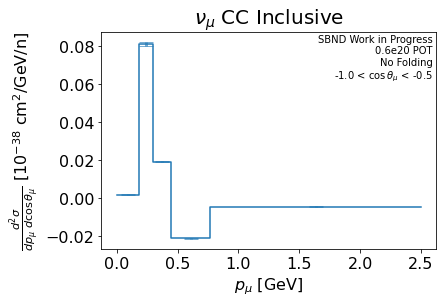

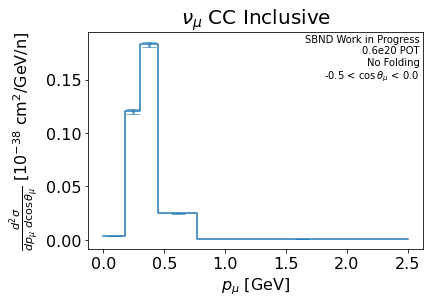

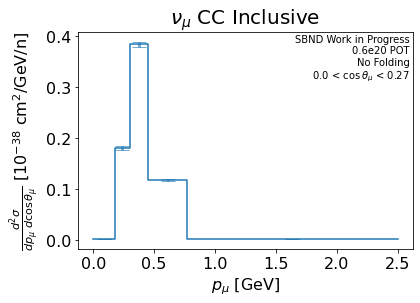

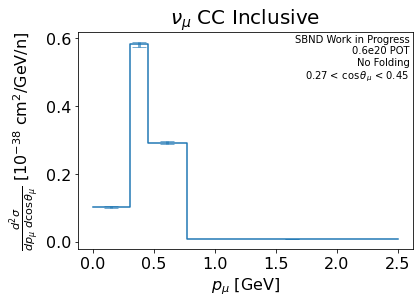

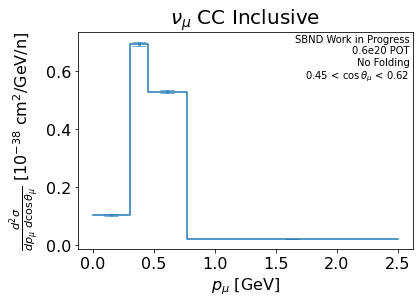

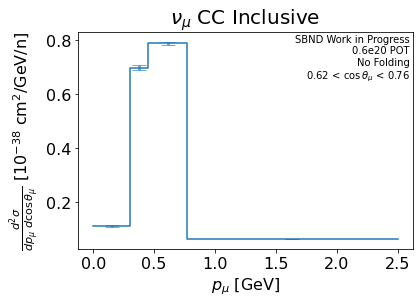

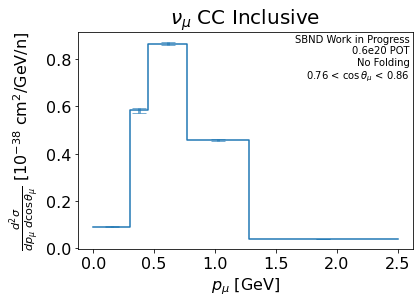

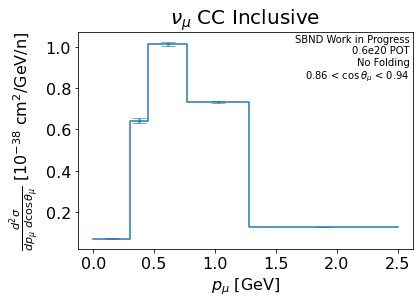

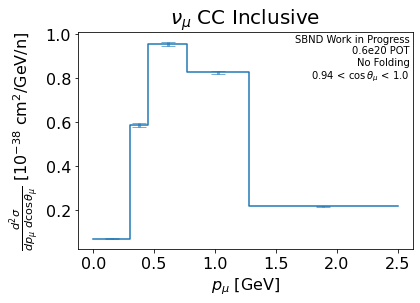

In [53]:
#d2x_dpdc
d2x_dpdc = np.zeros((len(COSTHETA_BINS)-1,len(MOMENTUM_BINS)-1))
errs = d2x_dpdc.copy()
scale = 1e38
for i in range(len(COSTHETA_BINS)-1):
    mom_bins = EdgesP[i]
    for j in range(len(mom_bins)-1):
        d2x_dpdc[i,j] = d2x_dpdc_dict[(i,j)]['d2x_dpdc']*scale
        errs[i,j] = d2x_dpdc_dict[(i,j)]['stat_unc']*d2x_dpdc_dict[(i,j)]['d2x_dpdc']*scale#*8.05

#Make plots in costheta bins
for i,c in enumerate(COSTHETA_BINS):
    if i == len(COSTHETA_BINS)-1: continue
    mom_bins = np.array(EdgesP[i])
    _d2x_dpdc = d2x_dpdc[i][:len(mom_bins)-1]
    _errs = errs[i][:len(mom_bins)-1]
    fig,ax = plt.subplots(figsize=(6,4))
    
    makeplot.plot_hist_edges(mom_bins,_d2x_dpdc,_errs,'',ax=ax)
    ax.set_xlabel(r'$p_\mu$ [GeV]')
    ax.set_ylabel(r'$\frac{d^2\sigma}{dp_\mu \ d\cos\theta_\mu}$ [$10^{-38}$ cm$^2$/GeV/n]')
    ax.set_title(r'$\nu_\mu$ CC Inclusive')
    plotters.set_style(ax)
    plotters.add_label(ax,LABEL+'\nNo Folding\n'+fr'{c} < $\cos\theta_\mu$ < {COSTHETA_BINS[i+1]}',where='topright')
    #plotters.add_label(ax,f'$\cos\\theta_{{\mu}}$ bin {i}',where='topleft')
    if SAVE_PLOT:
        plotters.save_plot(f'd2dx_dpdc_costheta_{i}',fig=fig,folder_name=PLOT_DIR)
        #plt.close()


In [56]:
NUMU_INTEGRATED_FLUX/1e11

9.780976076555024

In [16]:
d2x_dpdc_dict[(0,0)]

{'dc': 0.5,
 'dp': 0.18,
 'eff': 0.4074074074074073,
 'pur': 0.6111111111111109,
 'n_i': 88.5315527469295,
 'b_i': 56.33826083895514,
 'stat_unc': 0.08308278564283073,
 'd2x_dpdc': 5.084410192372961e-40,
 'mom_bins': [0.0, 0.18, 0.3, 0.45, 0.77, 2.5]}

In [111]:
slc.data.best_muon.keys()

MultiIndex([(    'cont_tpc',            '',              '',    ''),
            (    'costheta',            '',              '',    ''),
            (      'dazzle',   'muonScore',              '',    ''),
            (      'dazzle',         'pdg',              '',    ''),
            (      'dazzle',   'pionScore',              '',    ''),
            (      'dazzle', 'protonScore',              '',    ''),
            (         'dir',           'x',              '',    ''),
            (         'dir',           'y',              '',    ''),
            (         'dir',           'z',              '',    ''),
            (         'end',           'x',              '',    ''),
            (         'end',           'y',              '',    ''),
            (         'end',           'z',              '',    ''),
            (      'energy',            '',              '',    ''),
            (         'len',            '',              '',    ''),
            (           'p',      